# Bet Classifier - Determingin how much to bet in Blackjack

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from classifier_utils import *
from classifier_model import *
from catboost import CatBoostRegressor

In [2]:
#set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


## Load the dataset

In [3]:
dataset = pd.read_csv('bets_dataset.csv',dtype=np.float32)
print(dataset.head())

   Ace  Two  Three  Four  Five  Six  Seven  Eight  Nine   Ten  Reward
0  0.0  0.0    0.0   0.0   0.0  1.0    0.0    0.0   0.0   0.0    -0.5
1  0.0  0.0    0.0   0.0   0.0  0.0    0.0    0.0   0.0   0.0     1.5
2  4.0  2.0    3.0   3.0   2.0  3.0    3.0    2.0   4.0  10.0    -1.0
3  0.0  0.0    1.0   0.0   0.0  0.0    0.0    0.0   0.0   0.0     1.0
4  2.0  2.0    3.0   2.0   4.0  3.0    3.0    2.0   1.0  10.0     2.0


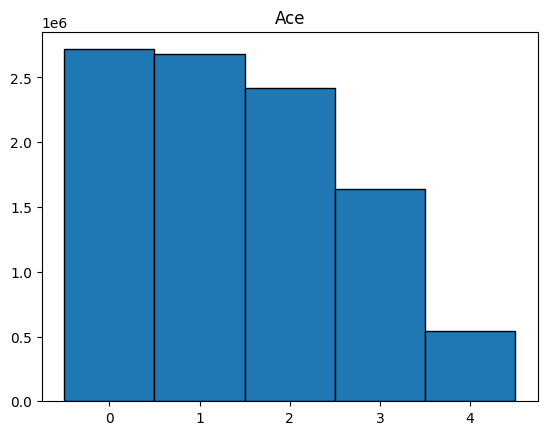

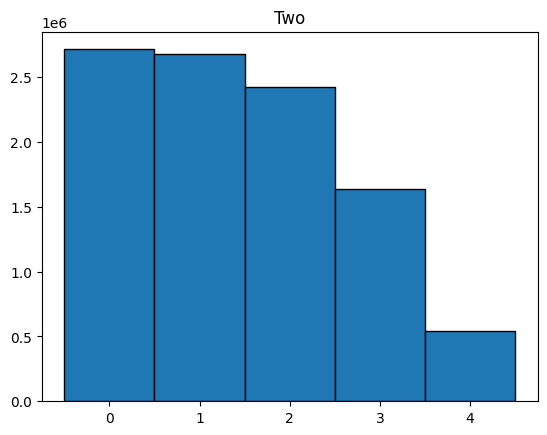

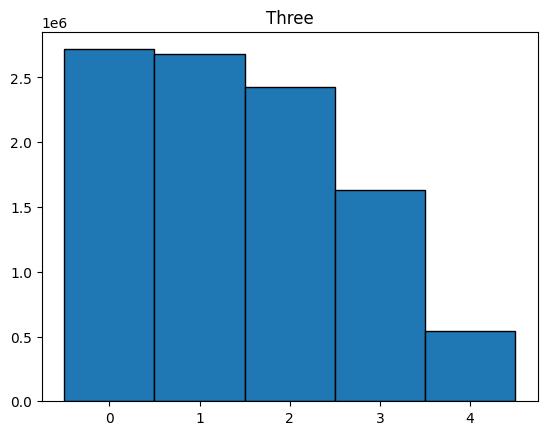

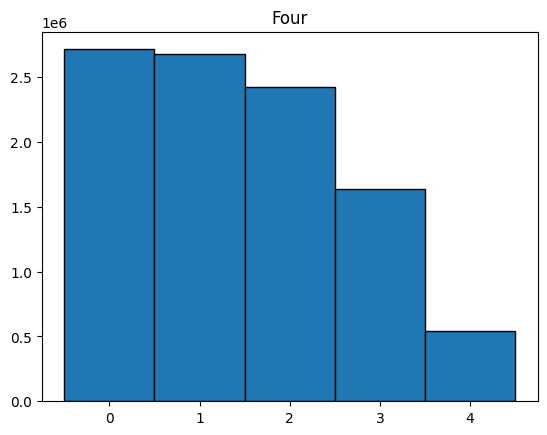

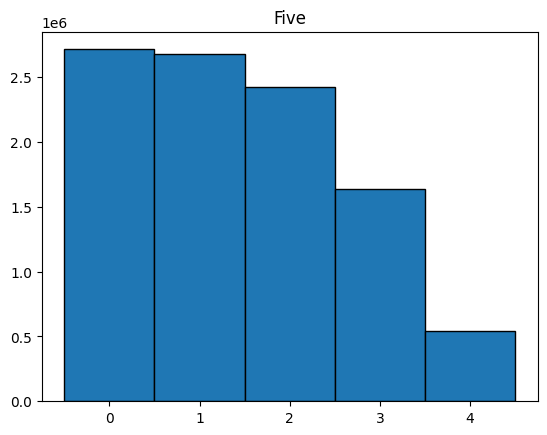

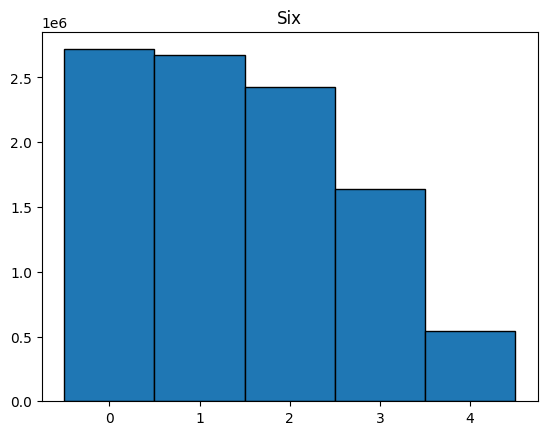

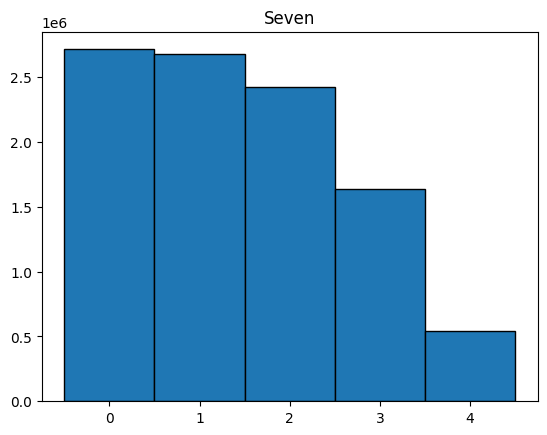

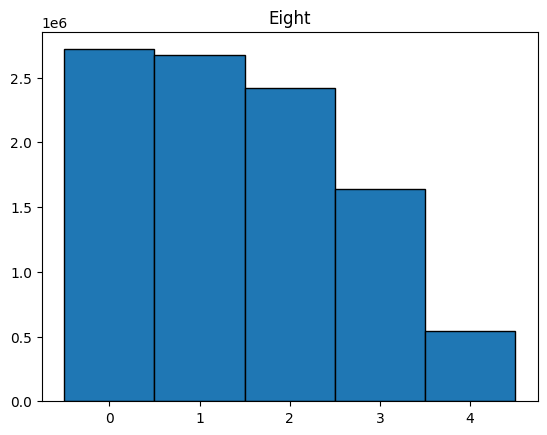

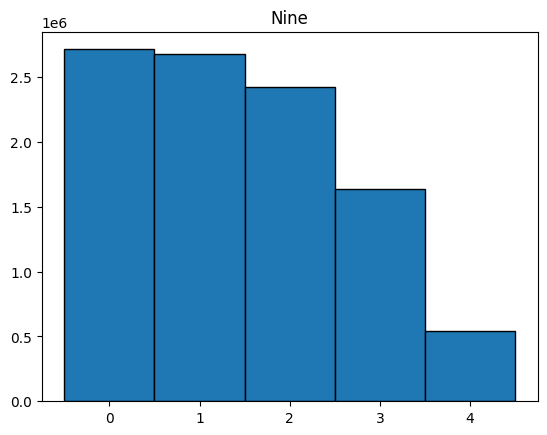

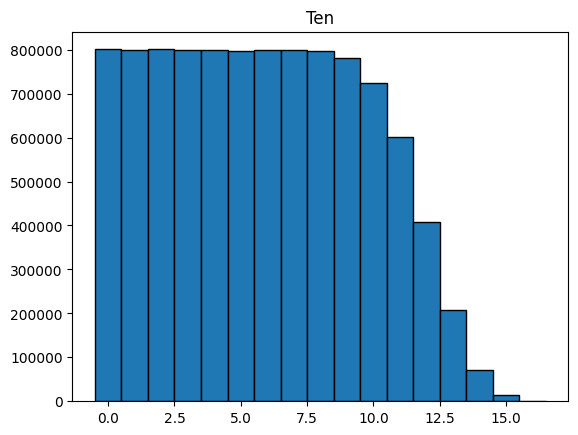

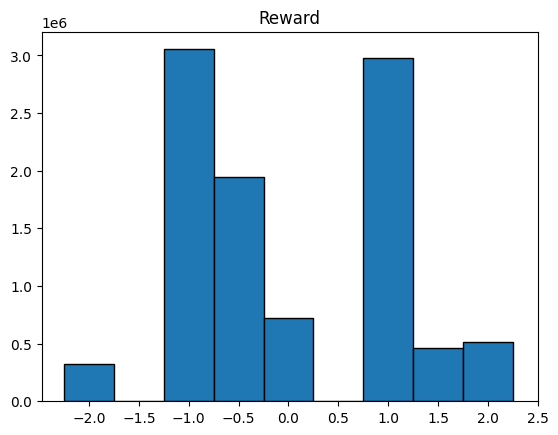

In [4]:
#print histogram of all columns

for i,column in enumerate(dataset.columns):
    plt.figure()
    plt.title(column)
    if i <=8 :
        #center the bins around the integers
        plt.hist(dataset[column], bins=np.arange(dataset[column].min(), dataset[column].max()+2)-0.5, edgecolor='black')
    elif i == 9:
        plt.hist(dataset[column], bins=np.arange(dataset[column].min(), dataset[column].max()+2)-0.5, edgecolor='black')
    else:
        #center around half integers -2.25 to -1.75, -1.75 to -1.25, -1.25 to -0.75, -0.75 to -0.25, -0.25 to 0.25, 0.25 to 0.75, 0.75 to 1.25, 1.25 to 1.75, 1.75 to 2.25
        plt.hist(dataset[column], bins=np.arange(dataset[column].min(), dataset[column].max()+1, 0.5)-0.25, edgecolor='black')
        plt.xticks(np.arange(-2,3,0.5))
    
        


<BarContainer object of 17 artists>

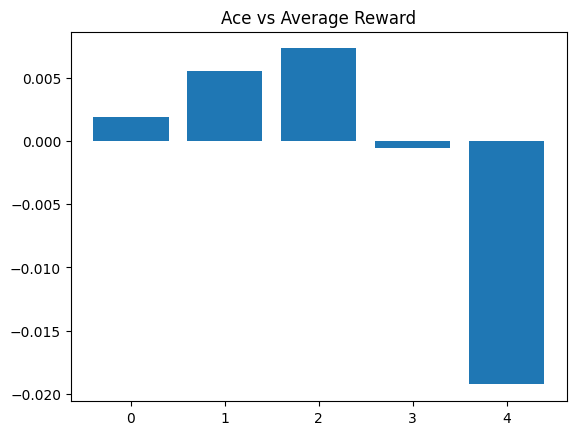

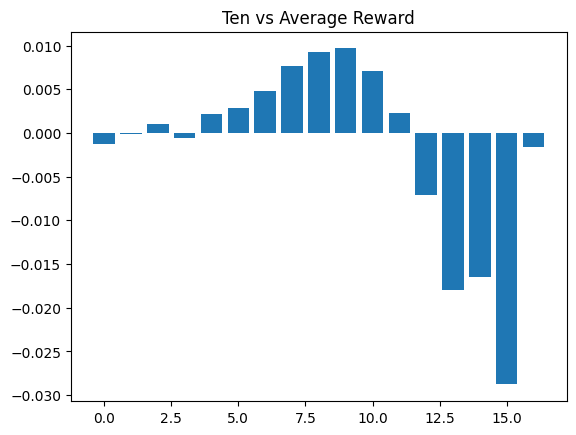

In [5]:
#plot aces against average reward
ace_avg_reward = dataset.groupby('Ace')['Reward'].mean()
tens_avg_reward = dataset.groupby('Ten')['Reward'].mean()

plt.figure()
plt.title('Ace vs Average Reward')
plt.bar(ace_avg_reward.index, ace_avg_reward.values)

plt.figure()
plt.title('Ten vs Average Reward')
plt.bar(tens_avg_reward.index, tens_avg_reward.values)

## Prepare dataloader for training

In [ ]:
# #add new column, Reward_class, which is 1 if Reward is positive, 0 if Reward is negative or 0
# dataset['Reward_class'] = dataset['Reward'].apply(lambda x: 1.0 if x > 0 else 0.0)

# plt.hist(dataset['Reward_class'], bins=[0,1,2], edgecolor='black')
# plt.title('Reward_class')
# plt.xticks([0,1])



In [6]:
#split dataset into training and validation
batch_size = 1000
dataset_usage = 1.0 #percentage of dataset to use in total
split = 0.8 #percentage of dataset_usafe to use for training
train_dataset = BetsDataset(dataset.iloc[:int(len(dataset)*dataset_usage*split)])
val_dataset = BetsDataset(dataset.iloc[int(len(dataset)*dataset_usage*split):int(len(dataset)*dataset_usage)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [12]:
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))


Training dataset size: 8000000
Validation dataset size: 2000000


In [13]:
catboost_model = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.1, loss_function='RMSE', task_type='GPU', devices='0:1', verbose=True)
catboost_model.fit(train_dataset.X, train_dataset.y, eval_set=(val_dataset.X, val_dataset.y), verbose=True)



0:	learn: 1.0450743	test: 1.0446397	best: 1.0446397 (0)	total: 69.8ms	remaining: 20.9s
1:	learn: 1.0450440	test: 1.0446096	best: 1.0446096 (1)	total: 132ms	remaining: 19.6s
2:	learn: 1.0450171	test: 1.0445844	best: 1.0445844 (2)	total: 190ms	remaining: 18.8s
3:	learn: 1.0449957	test: 1.0445621	best: 1.0445621 (3)	total: 250ms	remaining: 18.5s
4:	learn: 1.0449744	test: 1.0445408	best: 1.0445408 (4)	total: 309ms	remaining: 18.2s
5:	learn: 1.0449574	test: 1.0445250	best: 1.0445250 (5)	total: 367ms	remaining: 18s
6:	learn: 1.0449414	test: 1.0445077	best: 1.0445077 (6)	total: 420ms	remaining: 17.6s
7:	learn: 1.0449258	test: 1.0444932	best: 1.0444932 (7)	total: 471ms	remaining: 17.2s
8:	learn: 1.0449130	test: 1.0444793	best: 1.0444793 (8)	total: 521ms	remaining: 16.8s
9:	learn: 1.0448995	test: 1.0444661	best: 1.0444661 (9)	total: 575ms	remaining: 16.7s
10:	learn: 1.0448871	test: 1.0444530	best: 1.0444530 (10)	total: 629ms	remaining: 16.5s
11:	learn: 1.0448780	test: 1.0444435	best: 1.0444435 

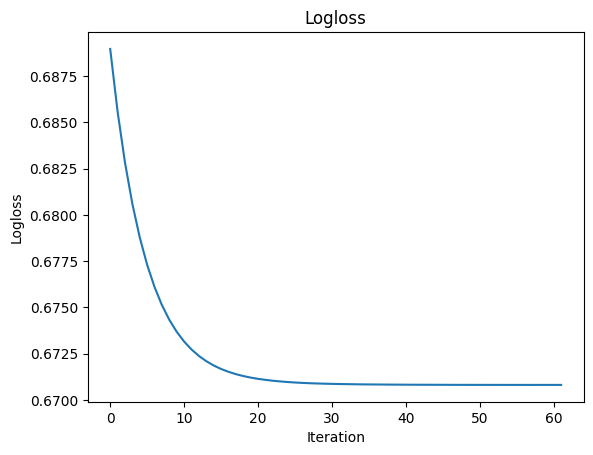

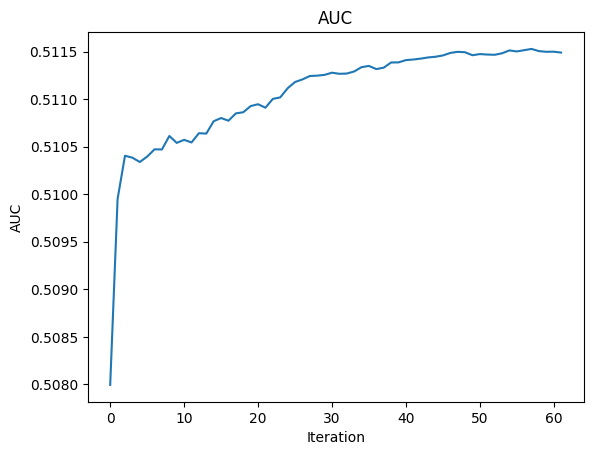

In [10]:
# val_pool = Pool(val_dataset.X, val_dataset.y)
# results = catboost_model.eval_metrics(val_pool, metrics=['Logloss', 'AUC'])

# plt.figure()
# plt.plot(results['Logloss'])
# plt.title('Logloss')
# plt.xlabel('Iteration')
# plt.ylabel('Logloss')
# plt.show()

# plt.figure()
# plt.plot(results['AUC'])
# plt.title('AUC')
# plt.xlabel('Iteration')
# plt.ylabel('AUC')
# plt.show()


In [14]:
predictions = catboost_model.predict(val_dataset.X)

#select threshold that procuces zero for 90% of the samples
threshold = np.percentile(predictions, 95)

final_predictions = np.where(predictions > threshold, 1, 0)



print(f"number of 1s: {np.sum(final_predictions)}")
print(f"number of 0s: {len(final_predictions) - np.sum(final_predictions)}")

number of 1s: 100000
number of 0s: 1900000


In [17]:
odds = 10.0

#calculate average return
avg_return_constant_bet = val_dataset.rewards.mean()
print('Average return with constant bet with odds of 10:', avg_return_constant_bet)

dynamic_bet_return = np.where(final_predictions == 0, val_dataset.rewards, val_dataset.rewards * odds)
print('Average return with dynamic bet:', dynamic_bet_return.mean())

print('Average return when classifier says to bet high:', val_dataset.rewards[final_predictions == 1].mean())
print('Average return when classifier says to bet low:', val_dataset.rewards[final_predictions == 0].mean())

Average return with constant bet: 0.0022625
Average return with dynamic bet: 0.04379525
Average return when classifier says to bet high: 0.092295
Average return when classifier says to bet low: -0.0024760526


In [18]:
# save model
catboost_model.save_model('catboost_model.cbm')

In [20]:
np.save('threshold.npy', threshold)